In [7]:
import pybedtools
import pandas as pd
import numpy as np
from pybedtools import BedTool

In [8]:
annotation_dict = {
        'centipede_hepg2': '/u/project/ernst/dincer/tiling_2020/data/processed/centipede/centipede_HepG2.hg19.bed',
        'siphy-pi': '/u/project/ernst/dincer/tiling_2020/data/raw/siphy/hg19_29way_pi_lods_elements_12mers.chr_specific.fdr_0.1_with_scores.txt.gz',
        'dnaseEncode_hepg2': '/u/project/ernst/dincer/tiling_2020/data/annotations/wgEncodeUwDnaseHepg2PkRep1.narrowPeak.gz',
        'H3K27ac_hepg2': '/u/home/m/mudiyang/scratch/aug7/E118-H3K27ac.imputed.narrowPeak.sorted.bed',
        'H3K9ac_hepg2': '/u/home/m/mudiyang/scratch/aug7/E118-H3K9ac.imputed.narrowPeak.sorted.bed',
        'H3K27me3_hepg2': '/u/home/m/mudiyang/scratch/aug7/E118-H3K27me3.imputed.narrowPeak.sorted.bed',
        'dnaseRoadmap_hepg2': '/u/home/m/mudiyang/scratch/aug7/E118-DNase.imputed.narrowPeak.sorted.bed',
    }

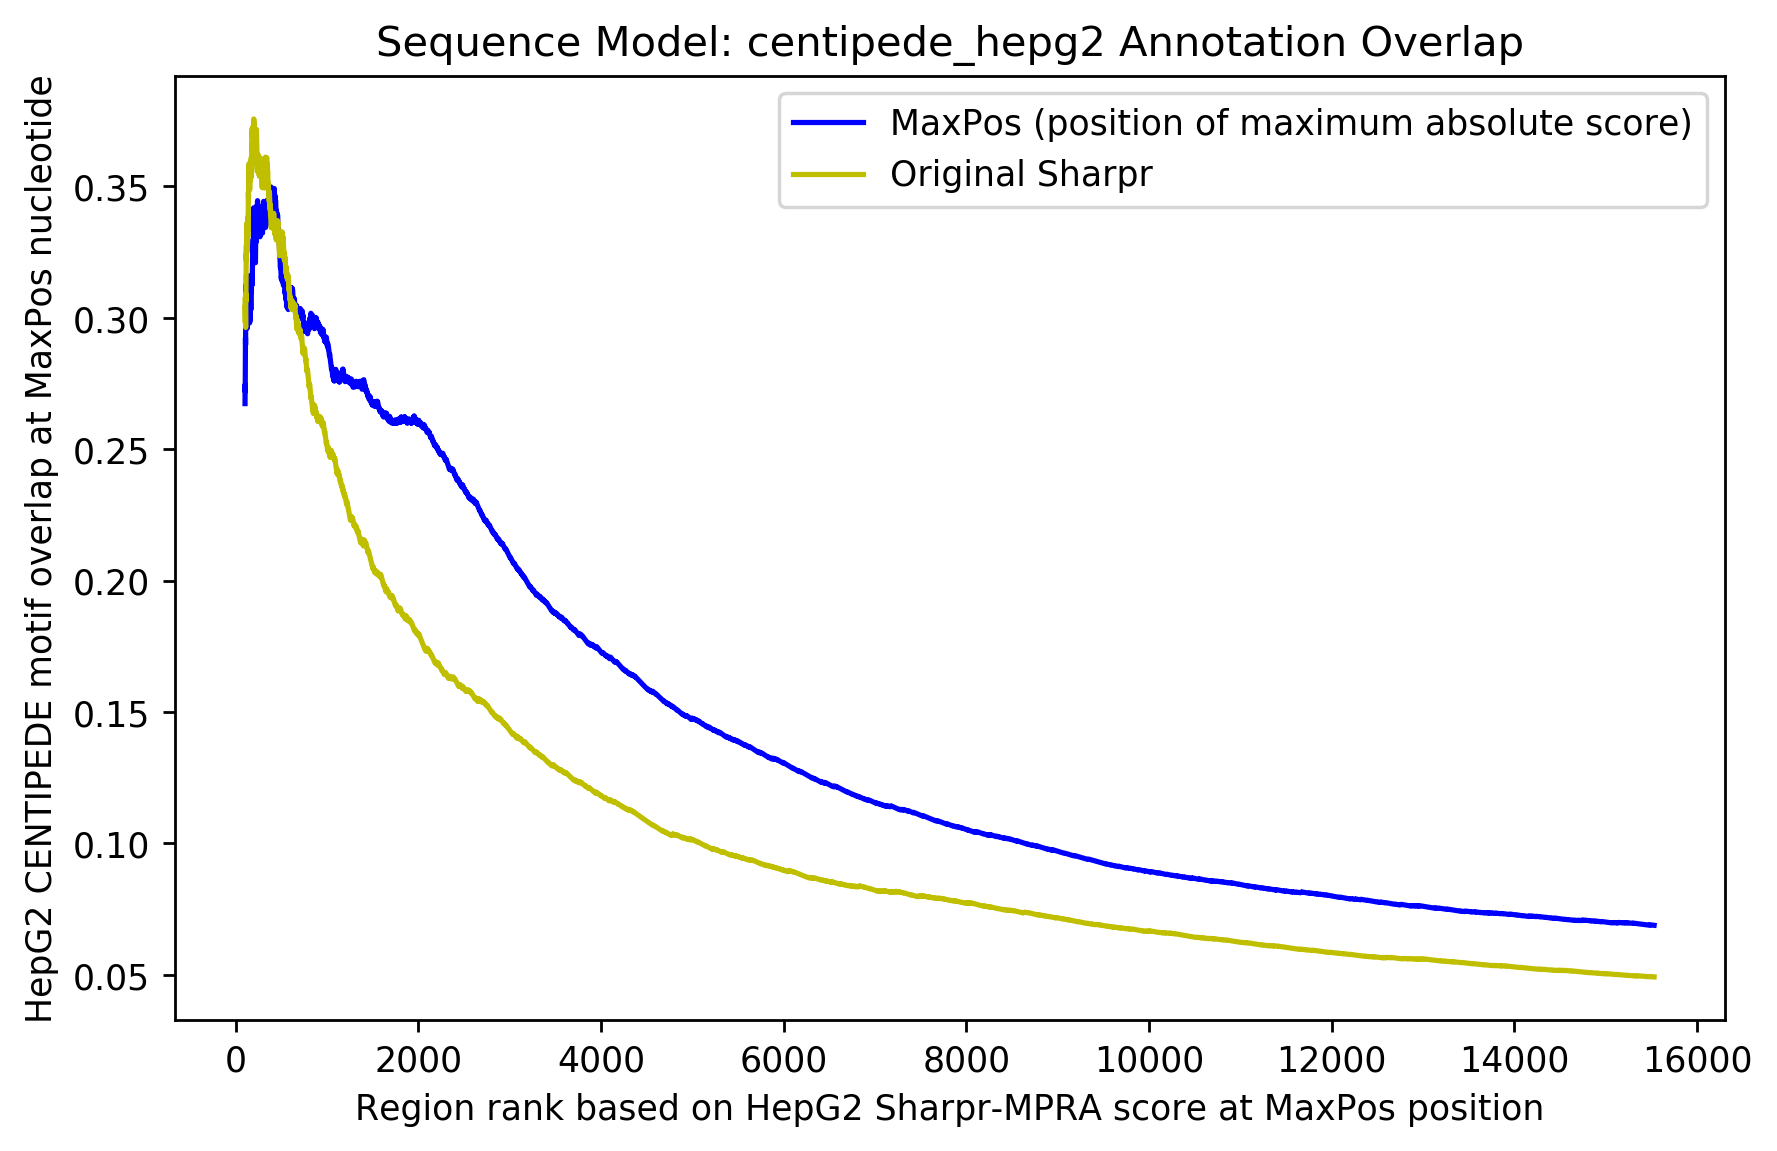

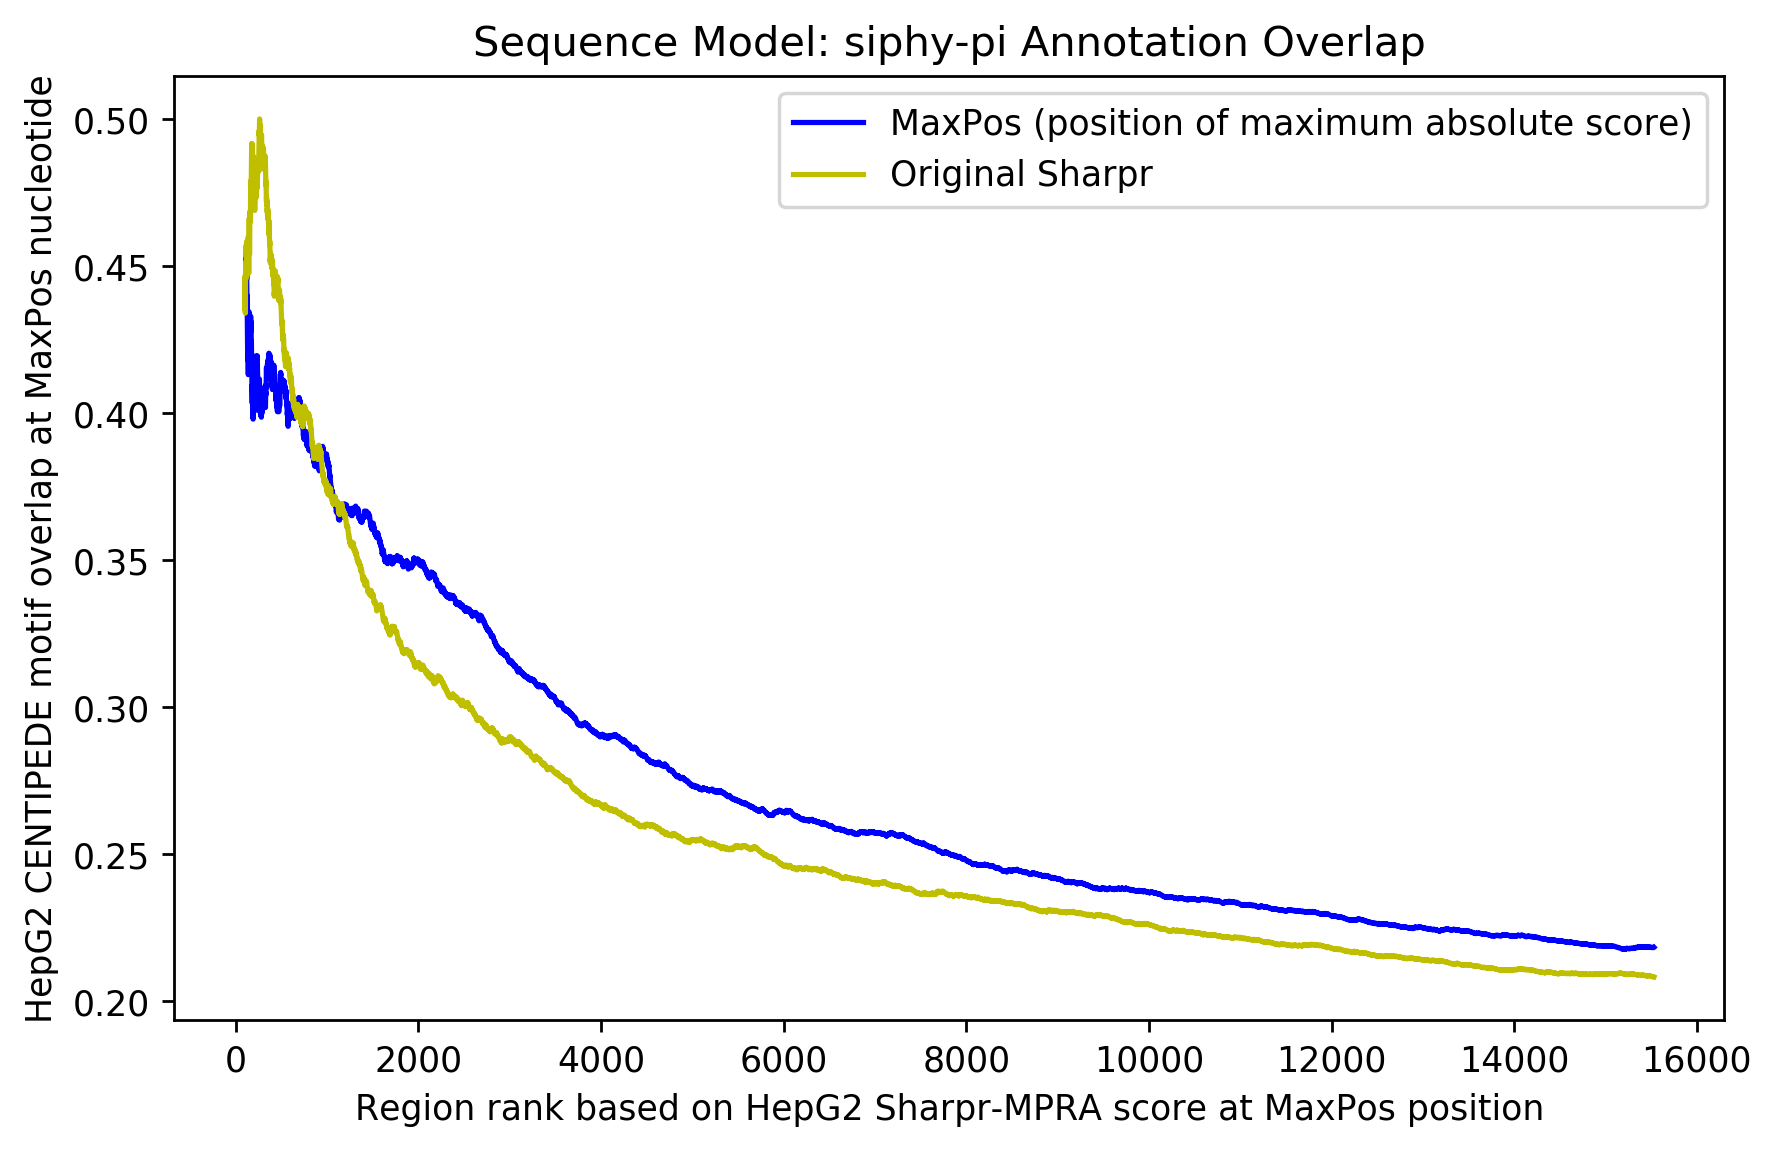

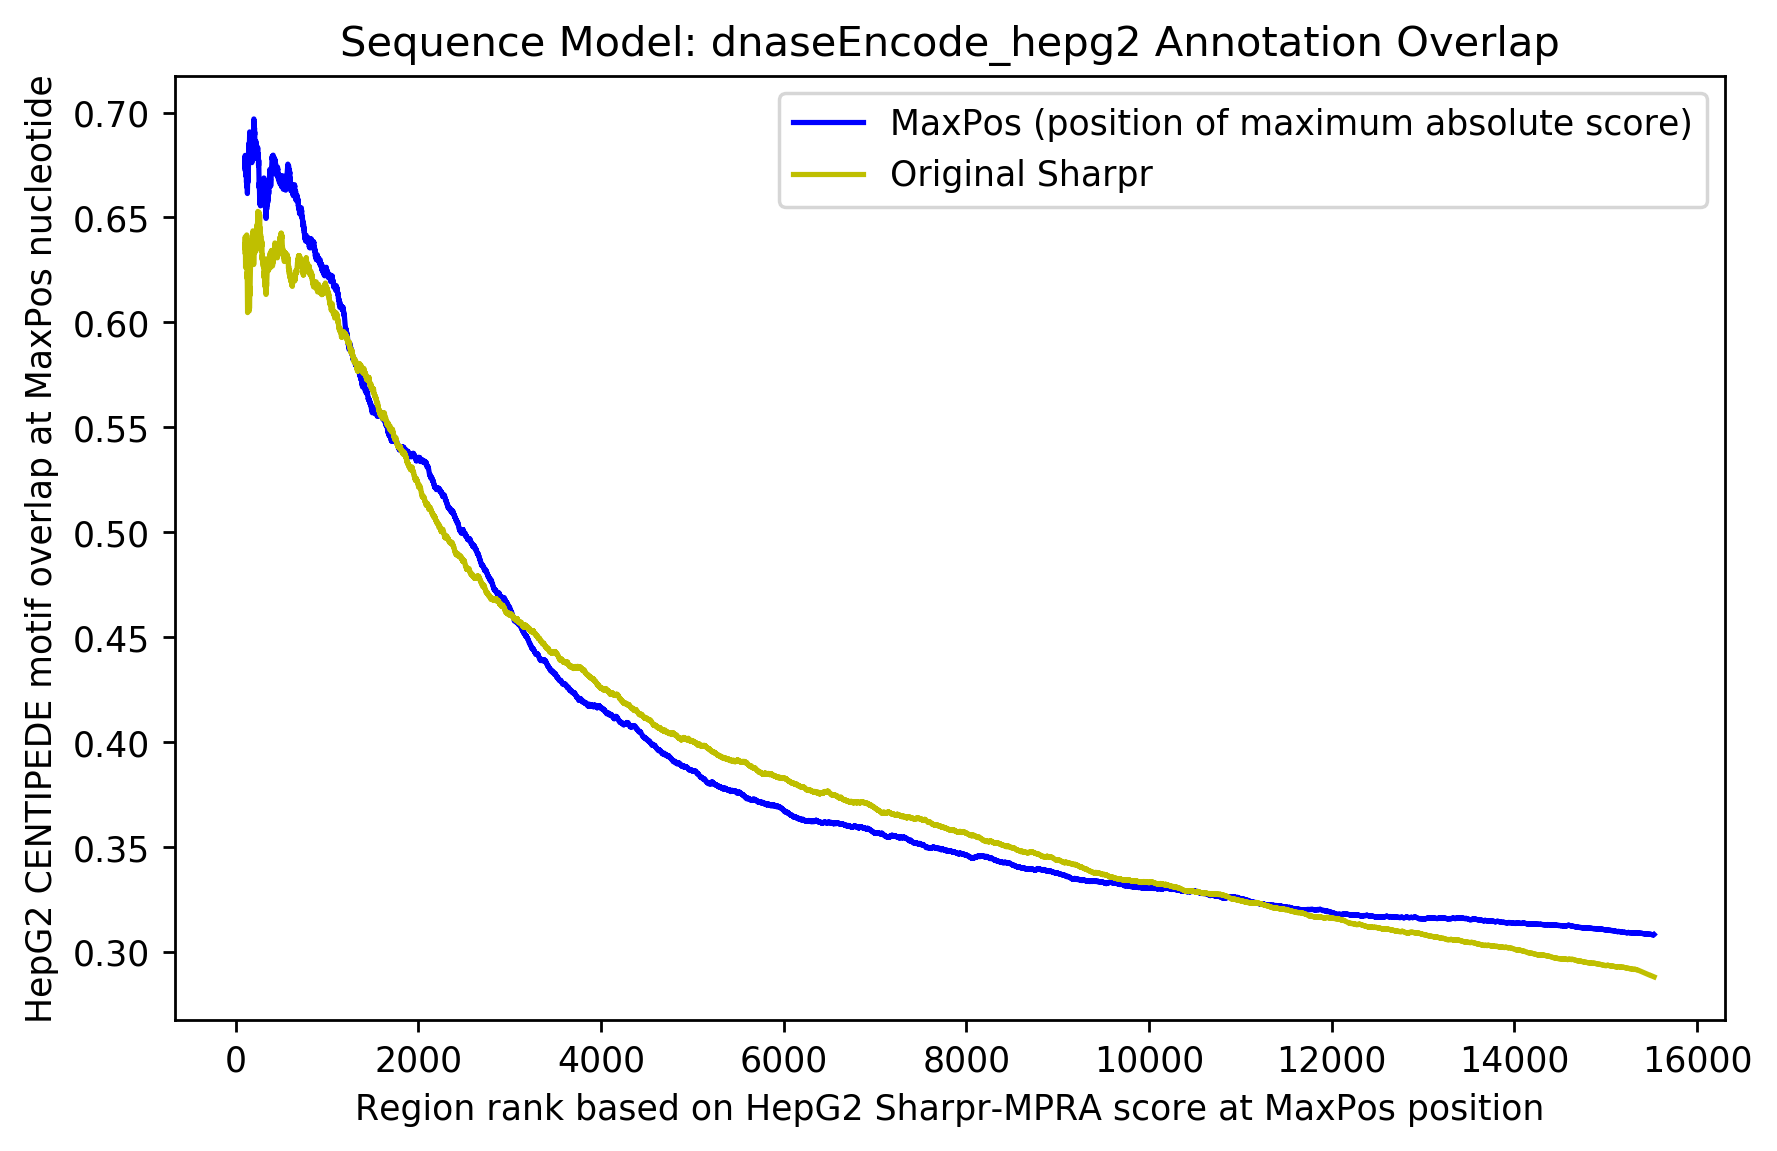

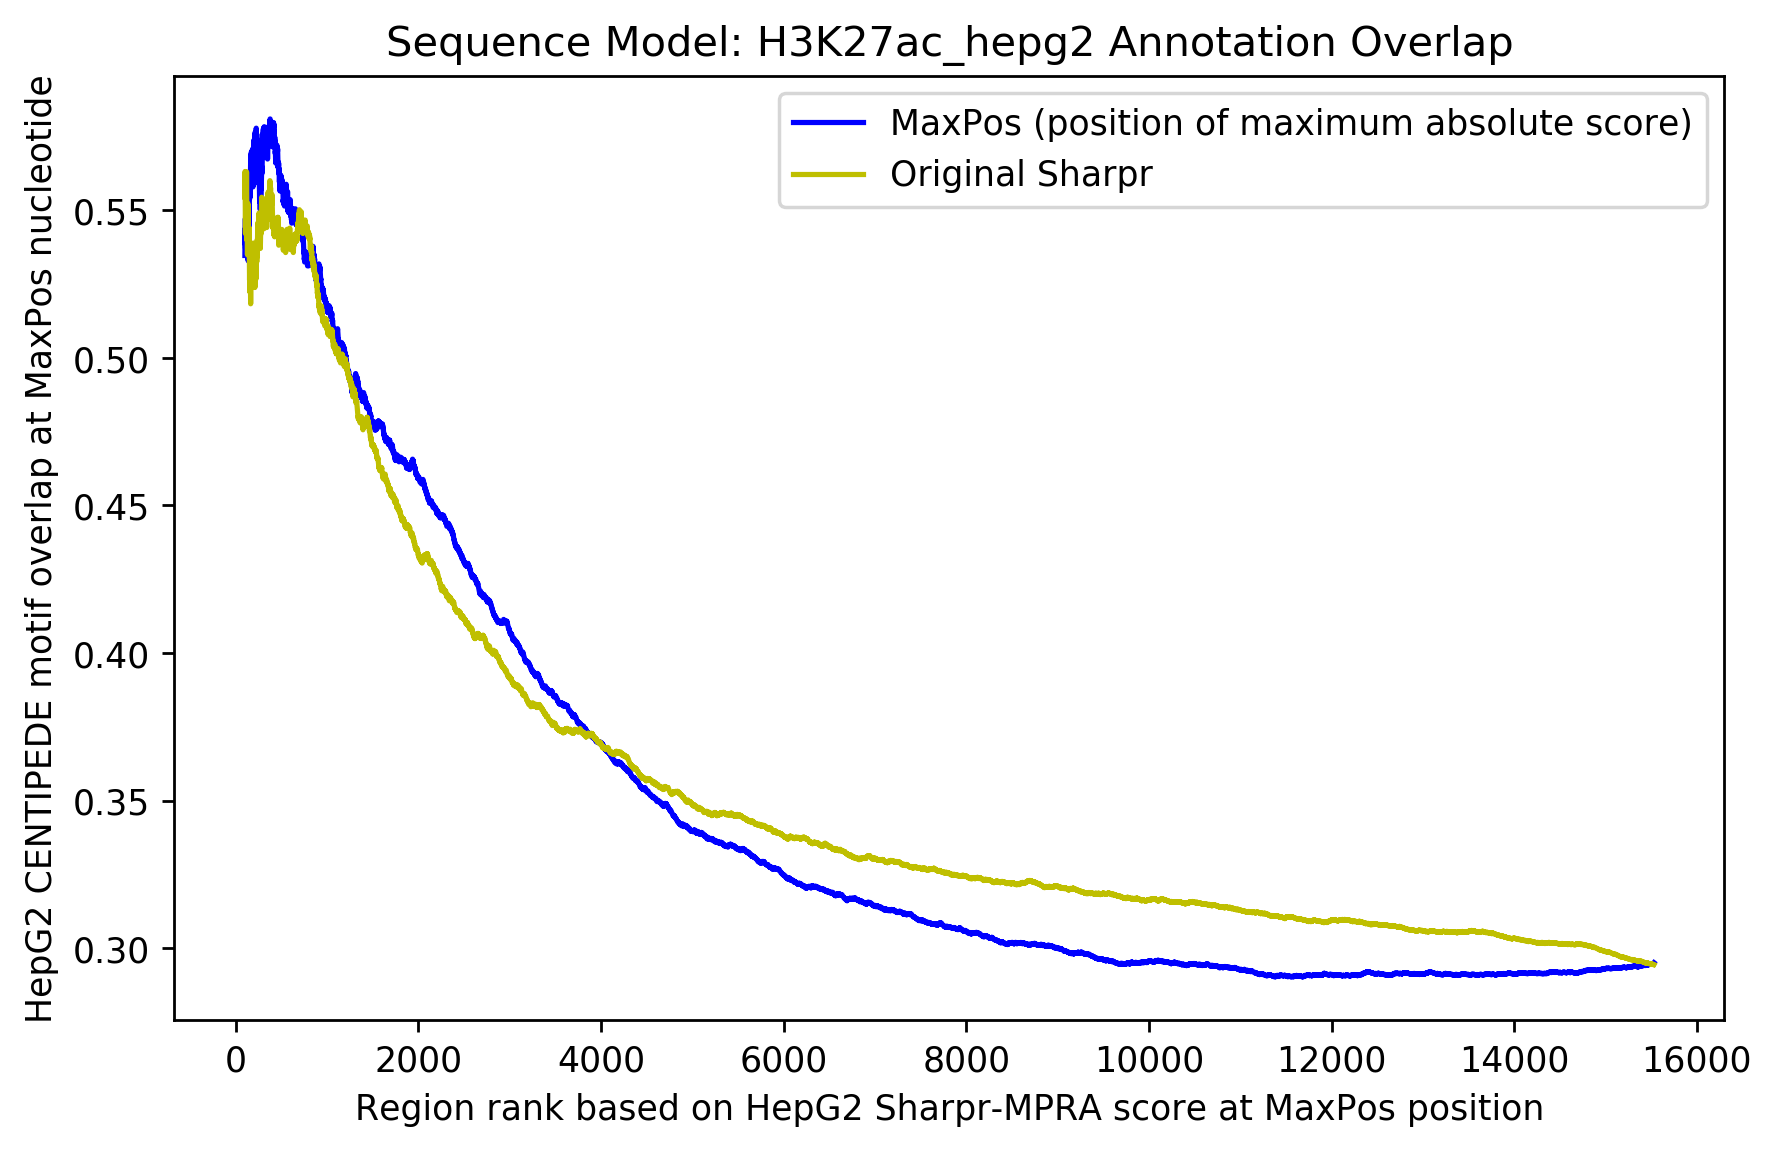

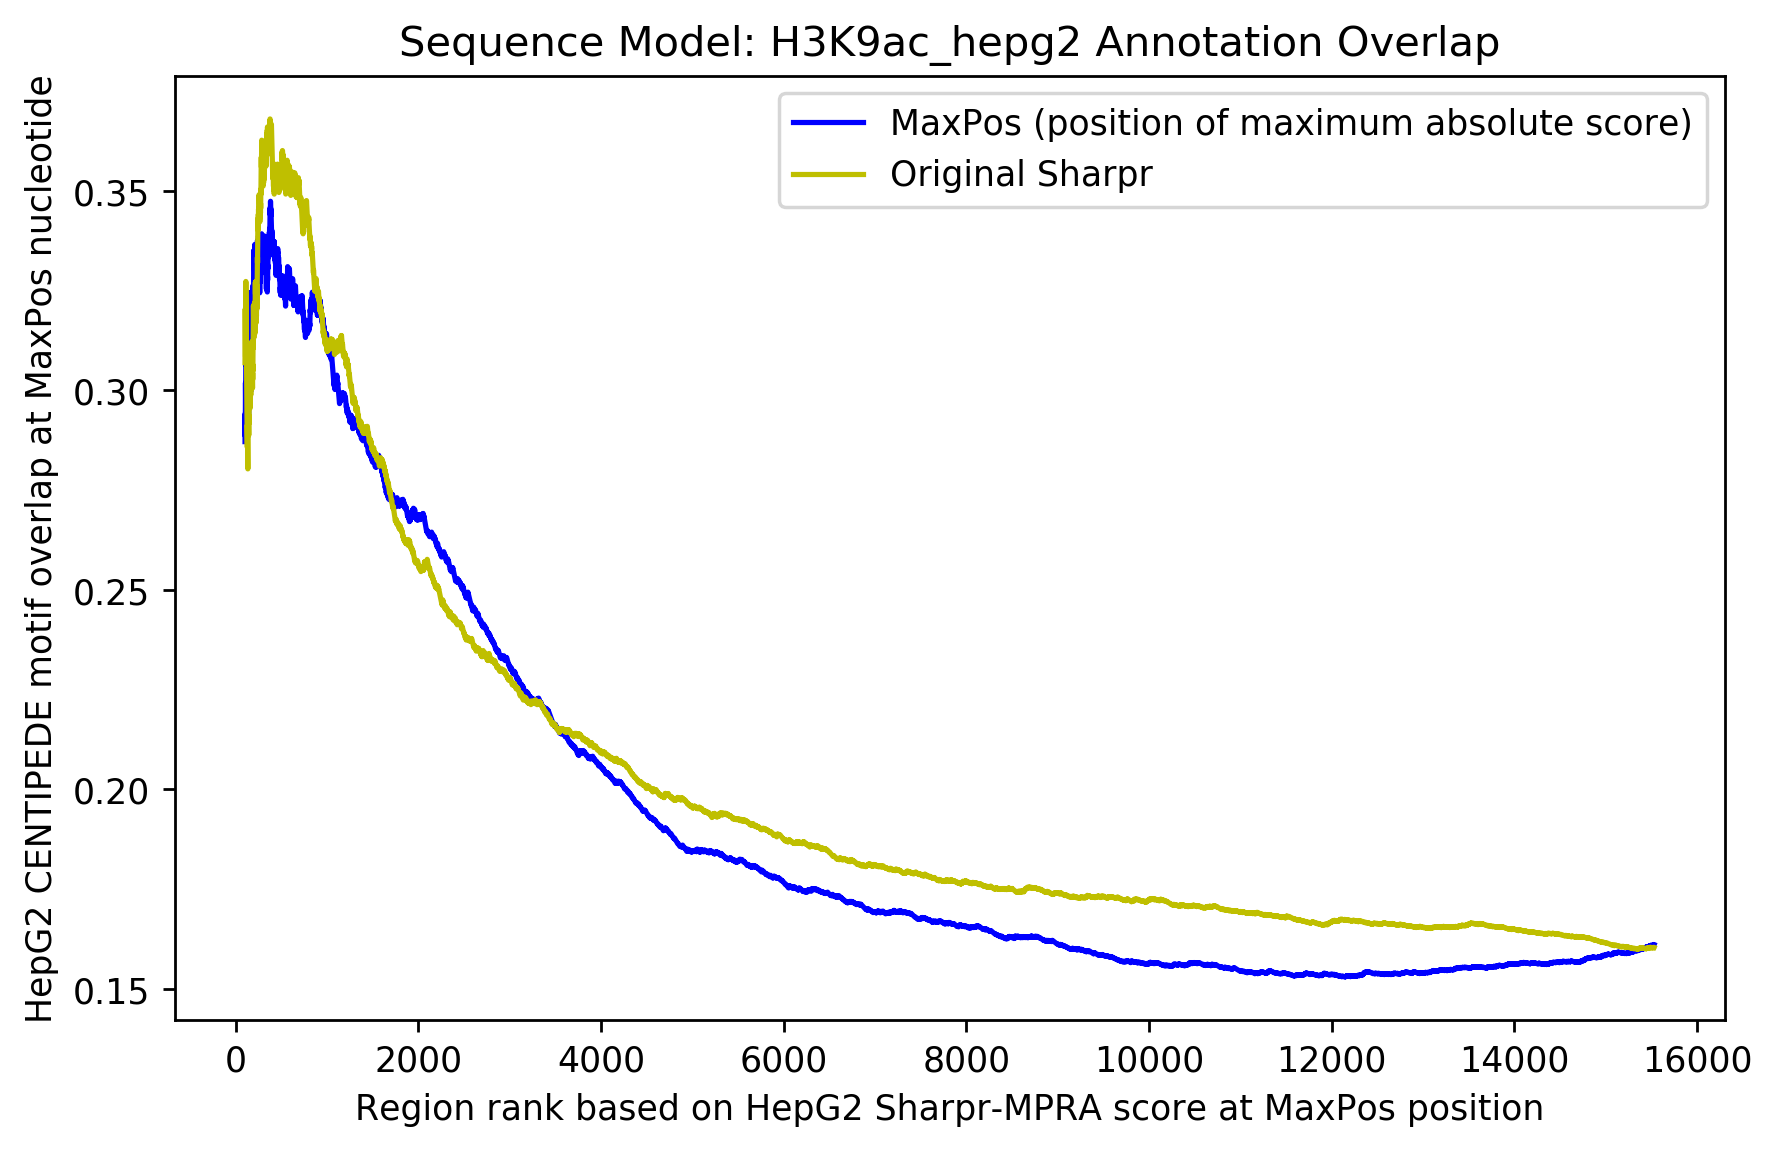

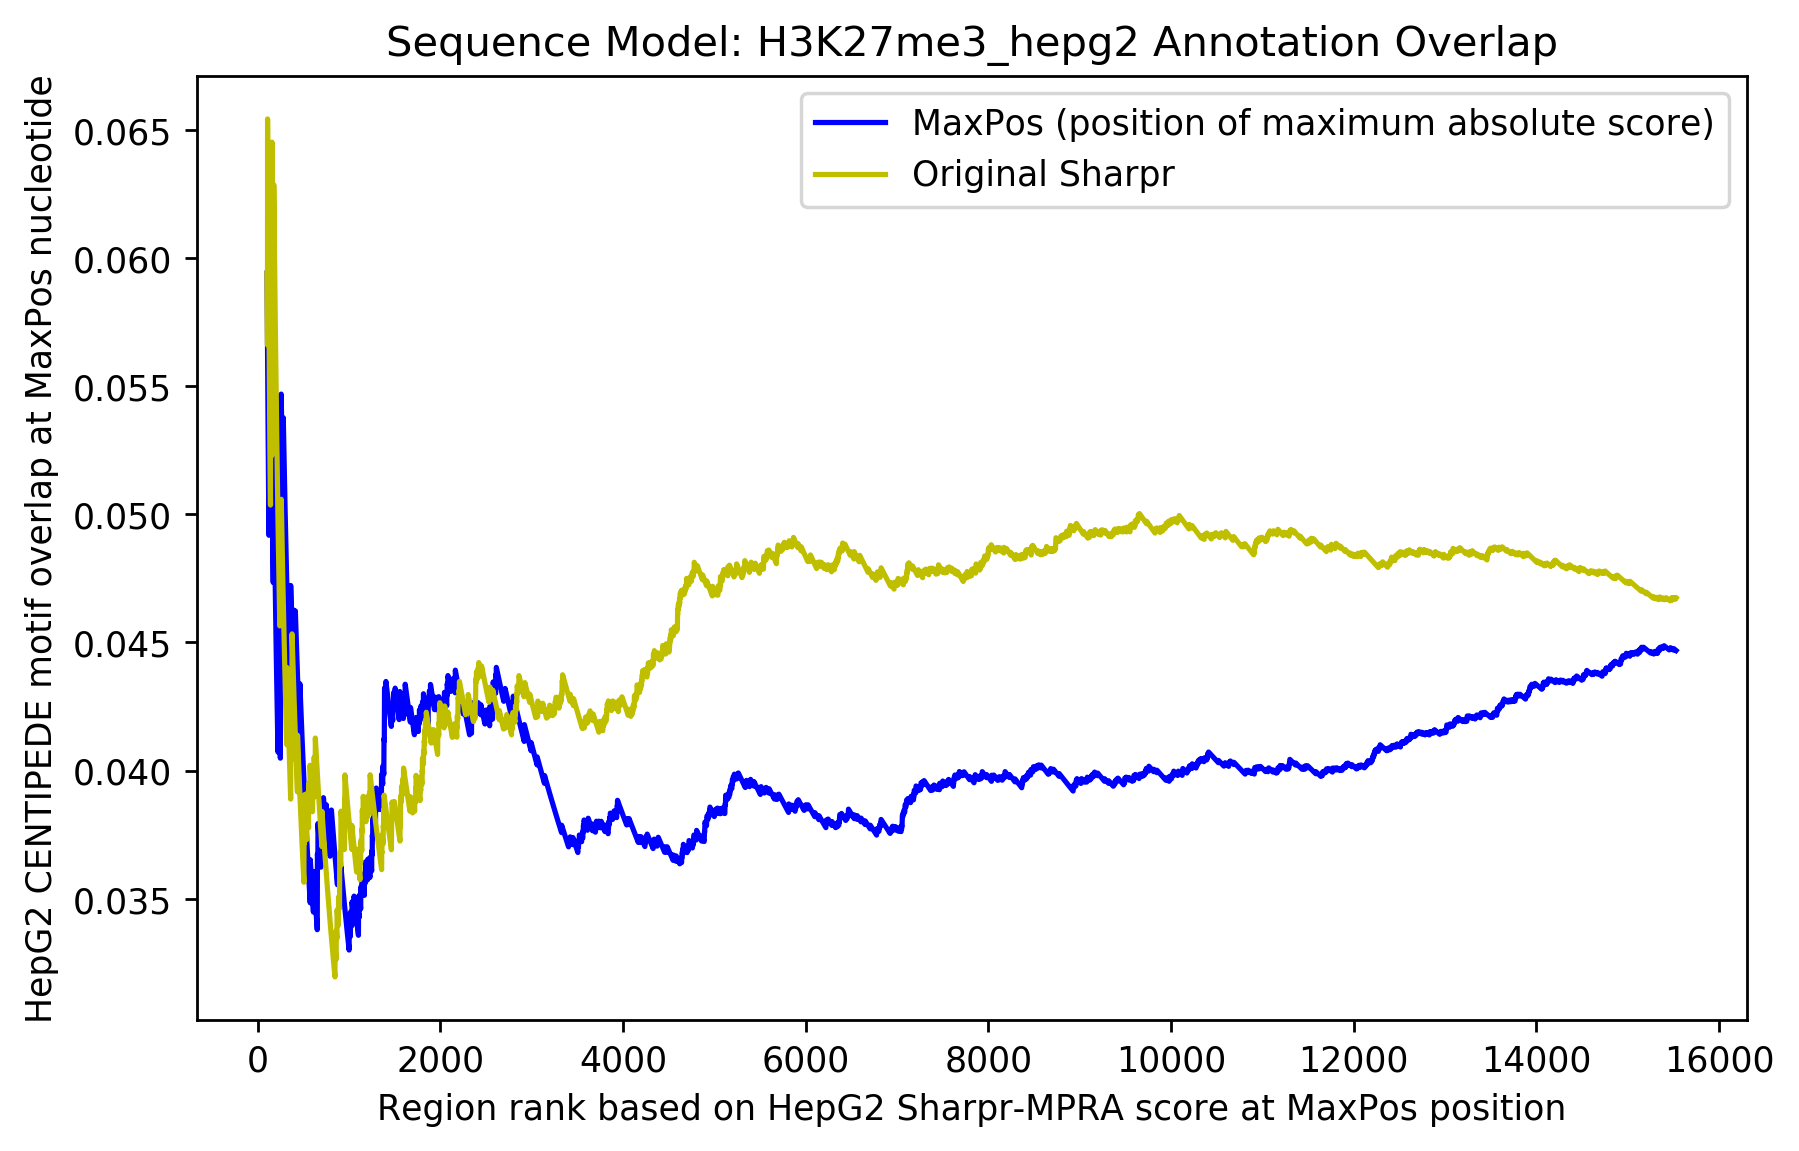

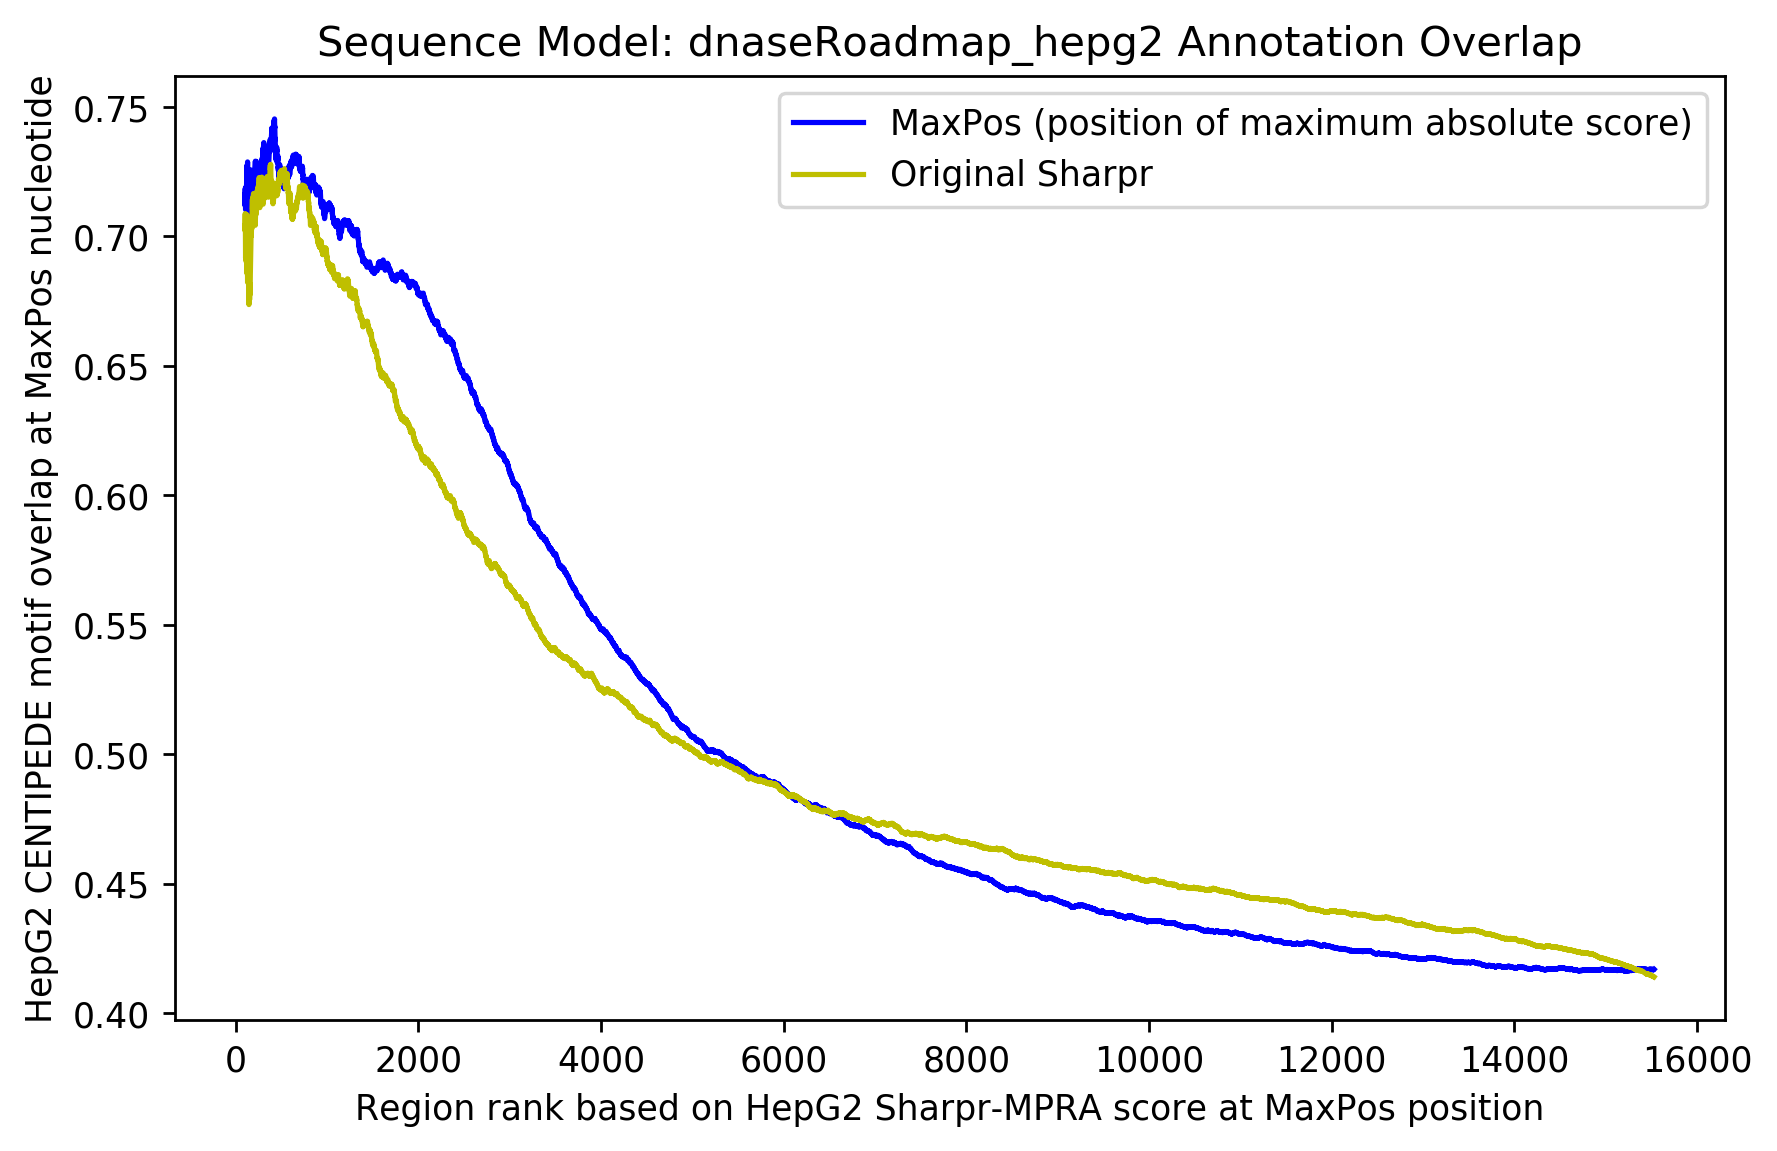

In [9]:
for annot in annotation_dict:
    curr_annotation = BedTool(annotation_dict[annot])
    # this code replicates Figure 3d in the SHARPR paper

    # the following code is meant to help you implement your own version
    # and will not work unless you make some modifications

    from pybedtools import BedTool

    path = '/u/home/m/mudiyang/scratch/Tile_Prediction_Regressors/Megan_Model/SHARPR_Scores/Megan.pkl'

    predicted = pd.read_pickle(path)

    df = predicted

    coord_df = pd.read_pickle('/u/home/m/mudiyang/scratch/Scaleup_counts_sequences/coords_Megan_SHARPR.pkl')

    coord_df.columns = ['chrom','start','stop']

    absmax_idx = df.abs().idxmax(axis=1)

    idx_d = {"sharpr_minP_model": absmax_idx}

    for current_idx, idx in idx_d.items():
        coord_df['absmax_idx'] = idx
        coord_df['absmax_pos'] = coord_df['start'].map(int) + coord_df['absmax_idx'].map(int)

        absmax_pos_df = pd.concat(
            [
                coord_df["chrom"],
                coord_df["absmax_pos"],
                (coord_df["absmax_pos"] + 1).rename("absmax_pos_"),
                coord_df.index.to_series(),
            ],
            axis=1,
        )

        sharpr_absmax = BedTool.from_dataframe(absmax_pos_df).sort()

        absmax_values = pd.Series(df.lookup(df.index, idx), index=df.index, name='absmax_values')

        centipede = curr_annotation

        hits = sharpr_absmax.intersect(centipede, c=True)
        hits_df = hits.to_dataframe().set_index('name').rename_axis('region_id')

        hits_df['absmax_values'] = absmax_values
        hits_df['abs_absmax_values'] = absmax_values.abs()

        hits_df = hits_df.sort_values('abs_absmax_values', ascending=False)

        hits_df['is_centipede'] = hits_df['score'] > 0

        hits_df['i'] = hits_df.reset_index().reset_index().set_index('region_id')['index']+1

        hits_df['centipede_cumsum'] = hits_df['is_centipede'].cumsum()

        hits_df[f'centipede_motif_overlap'] = (hits_df['centipede_cumsum']/hits_df['i'])

        hits_df = hits_df[hits_df['i'] > 100]

        absmax_df = hits_df[['i','centipede_motif_overlap']]

    # this code replicates Figure 3d in the SHARPR paper

    # the following code is meant to help you implement your own version
    # and will not work unless you make some modifications

    from pybedtools import BedTool

    SHARPR_Paper = pd.read_csv('/u/home/m/mudiyang/scratch/SHARPR_Scores/HEPG2_SHARPR-MPRA_scores/basepredictions_HEPG2_ScaleUpDesign1and2_SV40P.txt',
                        sep='\t', index_col=0, header = None)

    SHARPR_Paper.columns = range(0,295)


    df = SHARPR_Paper

    coord_df = pd.read_pickle('/u/home/m/mudiyang/scratch/Scaleup_counts_sequences/coords_Megan_SHARPR.pkl')

    coord_df.columns = ['chrom','start','stop']

    absmax_idx = df.abs().idxmax(axis=1)

    idx_d = {"sharpr_minP_model": absmax_idx}

    for current_idx, idx in idx_d.items():
        coord_df['absmax_idx'] = idx
        coord_df['absmax_pos'] = coord_df['start'].map(int) + coord_df['absmax_idx'].map(int)

        absmax_pos_df = pd.concat(
            [
                coord_df["chrom"],
                coord_df["absmax_pos"],
                (coord_df["absmax_pos"] + 1).rename("absmax_pos_"),
                coord_df.index.to_series(),
            ],
            axis=1,
        )

        sharpr_absmax = BedTool.from_dataframe(absmax_pos_df).sort()

        absmax_values = pd.Series(df.lookup(df.index, idx), index=df.index, name='absmax_values')

        centipede = curr_annotation

        hits = sharpr_absmax.intersect(centipede, c=True)
        hits_df = hits.to_dataframe().set_index('name').rename_axis('region_id')

        hits_df['absmax_values'] = absmax_values
        hits_df['abs_absmax_values'] = absmax_values.abs()

        hits_df = hits_df.sort_values('abs_absmax_values', ascending=False)

        hits_df['is_centipede'] = hits_df['score'] > 0

        hits_df['i'] = hits_df.reset_index().reset_index().set_index('region_id')['index']+1

        hits_df['centipede_cumsum'] = hits_df['is_centipede'].cumsum()

        hits_df[f'centipede_motif_overlap'] = (hits_df['centipede_cumsum']/hits_df['i'])

        hits_df = hits_df[hits_df['i'] > 100]

        Orig_df = hits_df[['i','centipede_motif_overlap']]
        
        

    import matplotlib.pyplot as plt
    f, ax = plt.subplots(figsize=(8,5), dpi=250)
    plt.plot(
            hits_df['i'],
            absmax_df['centipede_motif_overlap'],'b', label = 'MaxPos (position of maximum absolute score)'
        )
    plt.plot(
            hits_df['i'],
            Orig_df['centipede_motif_overlap'], 'y', label = 'Original Sharpr'
        )
    plt.legend()
    plt.title('Sequence Model: %s Annotation Overlap'%annot)
    plt.xlabel("Region rank based on HepG2 Sharpr-MPRA score at MaxPos position")
    plt.ylabel("HepG2 CENTIPEDE motif overlap at MaxPos nucleotide")
    plt.show()